<a href="https://colab.research.google.com/github/mmouadd/Bachelorarbeit/blob/main/3%20Clustering%20mit%20RFM%20Analyse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from datetime import datetime

from scipy.stats import skew
from scipy.stats import kurtosis

# Ignores any warning
import warnings
warnings.filterwarnings("ignore")

sns.set(rc={'figure.figsize':(15, 8)})
sns.set_style("whitegrid")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('float_format', '{:f}'.format)

import matplotlib as mp
%matplotlib inline
import textwrap
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

In [2]:
# Definition einer Liste von Zeichenketten, die als fehlende Werte betrachtet werden sollen
missing_values = ['n/a', 'na', 'nan', '-', '--', 'null', 'Null', ' ', '-1', -1]

# Quelle der Daten
source = 'https://raw.githubusercontent.com/mmouadd/Bachelorarbeit/main/Datensatz/marketing_campaign.csv'

# Einlesen der Daten, wobei fehlende Werte entsprechend der definierten Liste behandelt werden
df = pd.read_csv(source, na_values = missing_values, delimiter=',')

# Zusätzliches Einlesen der Daten für die RFM-Analyse
df_rfm = pd.read_csv(source, sep=",")

# Anzeigen der ersten Zeilen des DataFrame für die RFM-Analyse
df_rfm.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.000000,0,0,04/09/2012,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.000000,1,1,08/03/2014,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.000000,0,0,21/08/2013,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.000000,1,0,10/02/2014,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.000000,1,0,19/01/2014,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0


In [3]:
# Berechnung der Gesamtausgaben (Spending) jedes Kunden über alle Produktkategorien
df_rfm['Spending']=df_rfm['MntWines']+ \
    df_rfm['MntFruits']+ \
    df_rfm['MntMeatProducts']+ \
    df_rfm['MntFishProducts']+ \
    df_rfm['MntSweetProducts']+ \
    df_rfm['MntGoldProds']

In [4]:
# Berechnung der Gesamtzahl der Einkäufe jedes Kunden über verschiedene Kanäle
df_rfm['Total_Purchases'] = df_rfm['NumDealsPurchases'] + \
    df_rfm['NumWebPurchases'] + \
    df_rfm['NumCatalogPurchases'] + \
    df_rfm['NumStorePurchases']

In [5]:
# Reduzieren des DataFrames auf die Spalten 'ID', 'Spending', 'Total_Purchases' und 'Recency'
df_rfm=df_rfm[['ID','Spending','Total_Purchases','Recency']]
df_rfm.head()

,ID,Spending,Total_Purchases,Recency
0,5524,1617,25,58
1,2174,27,6,38
2,4141,776,21,26
3,6182,53,8,26
4,5324,422,19,94


### Recency

In [6]:
# Erstellung eines neuen DataFrames, der nur die 'ID' und 'Recency' Spalten enthält
recency_df = df_rfm[['ID','Recency']]
recency_df.head()

,ID,Recency
0,5524,58
1,2174,38
2,4141,26
3,6182,26
4,5324,94


### Frequency

In [7]:
# Erstellung eines neuen DataFrames, der nur die 'ID' und 'Total_Purchases' Spalten enthält
frequency_df = df_rfm[['ID','Total_Purchases']]

# Zusammenführen von 'recency_df' und 'frequency_df' basierend auf der 'ID' Spalte
temp_df = recency_df.merge(frequency_df,on='ID')

frequency_df.head()

,ID,Total_Purchases
0,5524,25
1,2174,6
2,4141,21
3,6182,8
4,5324,19


### Monetary

In [8]:
# Erstellung eines neuen DataFrames, der nur die 'ID' und 'Spending' Spalten enthält
monetary_df = df_rfm[['ID','Spending']]
monetary_df.head()

,ID,Spending
0,5524,1617
1,2174,27
2,4141,776
3,6182,53
4,5324,422


#### Aggregation von DataFrames

In [9]:
# Zusammenführen von 'temp_df' und 'monetary_df' zur Erstellung eines aggregierten DataFrames
tx_user  = temp_df.merge(monetary_df,on='ID')

# Umbenennen der Spalten für eine klare Definition: 'ID', 'Recency', 'Frequency', 'Monetary'
tx_user.columns = ['ID','Recency','Frequency','Monetary']

tx_user.head()

,ID,Recency,Frequency,Monetary
0,5524,58,25,1617
1,2174,38,6,27
2,4141,26,21,776
3,6182,26,8,53
4,5324,94,19,422


#### Elbow

In [10]:
# Installation des scikit-learn-extra Pakets für den K-Medoids Algorithmus

!pip install scikit-learn-extra

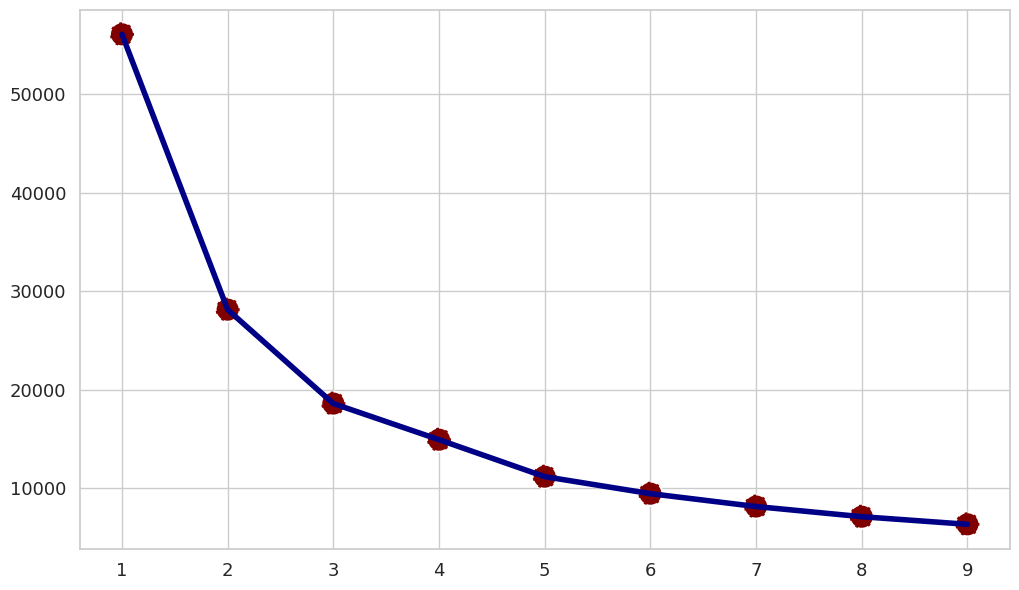

In [11]:
from sklearn_extra.cluster import KMedoids

# Initialisierung der Liste für die Summe der quadratischen Fehler (SSE)
sse=[]

# Extraktion der 'Recency'-Daten für die Clusteranalyse
tx_recency = tx_user[['Recency']]

# Durchführung der K-Medoids-Clusteranalyse für verschiedene Anzahlen von Clustern
for k in range(1, 10):
    kmedoids = KMedoids(n_clusters=k, random_state=0, max_iter=1000,init='k-medoids++',metric='euclidean').fit(tx_recency)
    tx_recency["clusters"] = kmedoids.labels_
    sse.append(kmedoids.inertia_)

# Visualisierung der SSE-Werte für verschiedene Clusteranzahlen
plt.figure(figsize=(12, 7))
sns.lineplot(x=range(1, 10), y=sse, color='#000087', linewidth = 4)
sns.scatterplot(x=range(1, 10), y=sse, s=300, color='#800000',  linestyle='--')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()

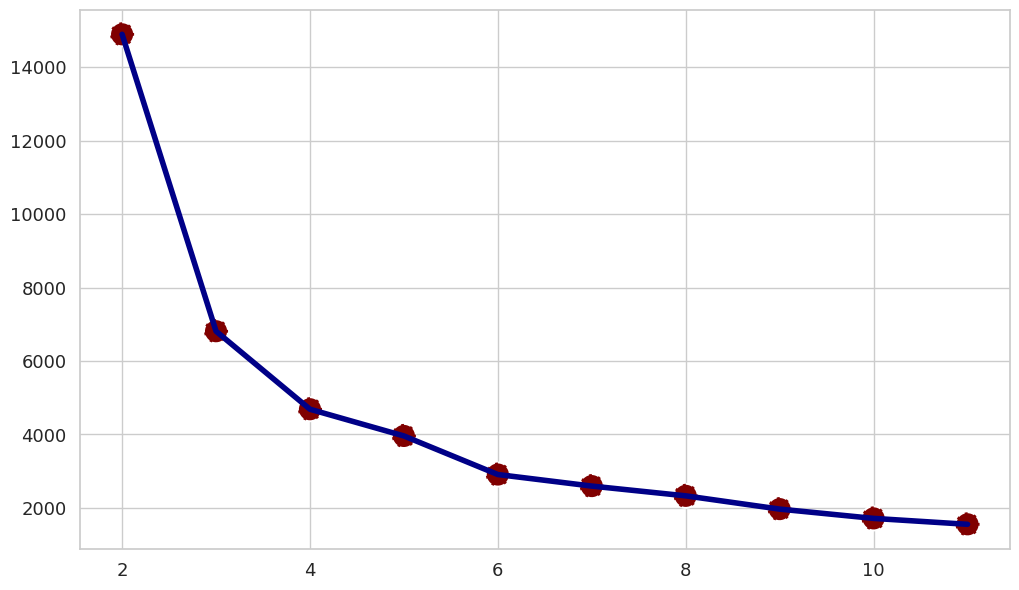

In [12]:
# Initialisierung der Liste für die Summe der quadratischen Fehler (SSE)
sse=[]

# Extraktion der 'Frequency'-Daten für die Clusteranalyse
tx_frequencyn = tx_user[['Frequency']]

# Durchführung der K-Medoids-Clusteranalyse für verschiedene Anzahlen von Clustern
for k in range(1, 11):
    kmedoids = KMedoids(n_clusters=k, random_state=0, max_iter=1000,init='k-medoids++',metric='euclidean').fit(tx_frequencyn)
    tx_frequencyn["clusters"] = kmedoids.labels_
    sse.append(kmedoids.inertia_)

# Visualisierung der SSE-Werte für verschiedene Clusteranzahlen
plt.figure(figsize=(12, 7))
sns.lineplot(x=range(2, 12), y=sse, color='#000087', linewidth = 4)
sns.scatterplot(x=range(2, 12), y=sse, s=300, color='#800000',  linestyle='--')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()

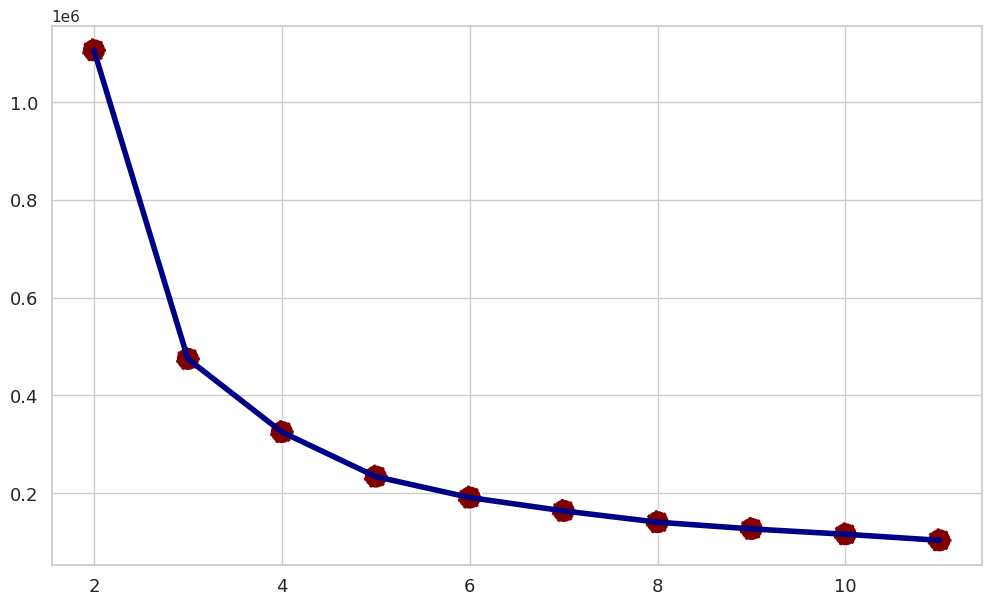

In [13]:
# Initialisierung der Liste für die Summe der quadratischen Fehler (SSE)
sse=[]

# Extraktion der 'Monetary'-Daten für die Clusteranalyse
tx_monetary = tx_user[['Monetary']]

# Durchführung der K-Medoids-Clusteranalyse für verschiedene Anzahlen von Clustern
for k in range(1, 11):
    kmedoids = KMedoids(n_clusters=k, random_state=0, max_iter=1000,init='k-medoids++',metric='euclidean').fit(tx_monetary)
    tx_monetary["clusters"] = kmedoids.labels_
    sse.append(kmedoids.inertia_)

# Visualisierung der SSE-Werte für verschiedene Clusteranzahlen
plt.figure(figsize=(12, 7))
sns.lineplot(x=range(2, 12), y=sse, color='#000087', linewidth = 4)
sns.scatterplot(x=range(2, 12), y=sse, s=300, color='#800000',  linestyle='--')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()

#### Erstellung von Recency-Clustern

In [14]:
#tx_recency = tx_user[['Recency']]

# Anwendung des K-Medoids-Algorithmus auf die 'Recency'-Daten mit 5 Clustern
kmedoids = KMedoids(n_clusters=5, random_state=0, max_iter=1000,init='k-medoids++',metric='euclidean').fit(tx_recency)
tx_user['RecencyCluster'] = kmedoids.predict(tx_recency)

# Funktion zur Neuordnung der Cluster, sodass niedrigere Cluster-Indizes niedrigeren Durchschnittswerten entsprechen
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

# Anwendung der Funktion zur Neuordnung der Recency-Cluster
tx_user = order_cluster('RecencyCluster', 'Recency',tx_user,False)

# Anzeigen der Statistiken für jeden Recency-Cluster
tx_user.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,392.000000,90.418367,5.137841,82.000000,86.000000,91.000000,95.000000,99.000000
1,430.000000,72.153488,5.593009,63.000000,67.000000,72.000000,77.000000,81.000000
2,472.000000,52.027542,5.706301,42.000000,47.750000,52.000000,56.000000,62.000000
3,490.000000,30.240816,6.173296,20.000000,25.000000,30.000000,36.000000,41.000000
4,456.000000,9.122807,5.849227,0.000000,4.000000,9.000000,14.000000,19.000000


#### Erstellung von Frequency-Clustern

In [15]:
tx_frequency = tx_user[['Frequency']]

# Anwendung des K-Medoids-Algorithmus auf die 'Frequency'-Daten mit 5 Clustern
kmedoids = KMedoids(n_clusters=5, random_state=0, max_iter=1000,init='k-medoids++',metric='euclidean').fit(tx_frequency)
tx_user['FrequencyCluster'] = kmedoids.predict(tx_frequency)

# Neuordnung der Frequency-Cluster, sodass höhere Cluster-Indizes höheren Durchschnittswerten entsprechen
tx_user = order_cluster('FrequencyCluster', 'Frequency',tx_user,True)

# Anzeigen der Statistiken für jeden Frequency-Cluster
tx_user.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,832.000000,6.608173,2.012077,0.000000,5.000000,7.000000,8.000000,10.000000
1,310.000000,12.996774,1.493239,11.000000,12.000000,13.000000,14.000000,15.000000
2,491.000000,17.940937,1.425201,16.000000,17.000000,18.000000,19.000000,20.000000
3,400.000000,22.770000,1.398925,21.000000,22.000000,23.000000,24.000000,25.000000
4,207.000000,28.246377,2.808132,26.000000,26.000000,27.000000,29.000000,44.000000


#### Erstellung von Monetary-Clustern

In [16]:
tx_monetary = tx_user[['Monetary']]

# Anwendung des K-Medoids-Algorithmus auf die 'Monetary'-Daten mit 5 Clustern
kmedoids = KMedoids(n_clusters=5, random_state=0, max_iter=1000,init='k-medoids++',metric='euclidean').fit(tx_monetary)
tx_user['MonetaryCluster'] = kmedoids.predict(tx_monetary)

# Neuordnung der Monetary-Cluster, sodass höhere Cluster-Indizes höheren Durchschnittswerten entsprechen
tx_user = order_cluster('MonetaryCluster', 'Monetary',tx_user,True)

# Anzeigen der Statistiken für jeden Monetary-Cluster
tx_user.groupby('MonetaryCluster')['Monetary'].describe()

,count,mean,std,min,25%,50%,75%,max
MonetaryCluster,,,,,,,,
0,939.000000,74.423855,53.566384,5.000000,36.000000,57.000000,97.500000,231.000000
1,398.000000,407.756281,110.683876,232.000000,311.000000,406.000000,493.750000,615.000000
2,314.000000,828.961783,113.620066,622.000000,731.000000,832.500000,928.000000,1009.000000
3,315.000000,1208.228571,122.867096,1012.000000,1102.500000,1189.000000,1315.000000,1445.000000
4,274.000000,1766.171533,243.027162,1449.000000,1574.000000,1701.500000,1919.000000,2525.000000


### Segmenterstellung

In [17]:
# Definition verschiedener Segmente basierend auf der Kombination von Recency- und Frequency-Clustern
segt_map = {
    r'44': 'Champions',
    r'43': 'Treue Bestandskunden',
    r'34': 'Treue Bestandskunden',
    r'33': 'Treue Bestandskunden',
    r'24': 'Treue Bestandskunden',
    r'23': 'Treue Bestandskunden',
    r'42': 'Potentielle treue Bestandskunden',
    r'41': 'Potentielle treue Bestandskunden',
    r'32': 'Potentielle treue Bestandskunden',
    r'31': 'Potentielle treue Bestandskunden',
    r'22': 'Kunden, die Aufmerksamkeit benötigen',
    r'21': 'Kunden, die Aufmerksamkeit benötigen',
    r'12': 'Kunden, die Aufmerksamkeit benötigen',
    r'11': 'Kunden, die Aufmerksamkeit benötigen',
    r'14': 'Wichtig, aber inaktiv',
    r'04': 'Wichtig, aber inaktiv',
    r'13': 'Gefährdete Kunden',
    r'03': 'Gefährdete Kunden',
    r'02': 'Gefährdete Kunden',
    r'20': 'Gefahr zur Inaktivität',
    r'40': 'Neue Kunden',
    r'30': 'Offenes Potential',
    r'10': 'Verloren',
    r'01': 'Verloren',
    r'00': 'Verloren',
}

# Kombinieren der Recency- und Frequency-Cluster zu einem Segment-String
tx_user['Segment'] = tx_user['RecencyCluster'].map(str) + tx_user['FrequencyCluster'].map(str)

# Ersetzen der kombinierten Cluster-Strings durch entsprechende Segmentbezeichnungen
tx_user['Segment'] = tx_user['Segment'].replace(segt_map, regex=True)

tx_user.sample(10)

,ID,Recency,Frequency,Monetary,RecencyCluster,FrequencyCluster,MonetaryCluster,Segment
309,6250,62,24,775,2,3,2,Treue Bestandskunden
843,359,33,19,504,3,2,1,Potentielle treue Bestandskunden
1407,10033,54,5,38,2,0,0,Gefahr zur Inaktivität
1538,2371,22,9,81,3,0,0,Offenes Potential
205,5955,27,16,1932,3,2,4,Potentielle treue Bestandskunden
1086,2021,47,33,1388,2,4,3,Treue Bestandskunden
1657,1448,33,9,51,3,0,0,Offenes Potential
1102,7079,38,32,1245,3,4,3,Treue Bestandskunden
237,9493,15,18,1808,4,2,4,Potentielle treue Bestandskunden
550,5209,21,19,638,3,2,2,Potentielle treue Bestandskunden


#### Metrikanalyse pro Segment

In [18]:
# Gruppieren der Daten nach 'Segment' und Berechnen der Durchschnittswerte und der Anzahl für jedes Segment
tx_user_viz = tx_user.groupby('Segment').agg({
    'Recency': 'mean',    # Durchschnitt der 'Recency'-Werte
    'Frequency': 'mean',  # Durchschnitt der 'Frequency'-Werte
    'Monetary': ['mean', 'count'],  # Durchschnitt und Anzahl der 'Monetary'-Werte
}).round(1) # Rundung der Werte auf eine Dezimalstelle


# Anzeigen der aggregierten Daten
tx_user_viz

Recency Frequency    Monetary      
                                          mean      mean        mean count
Segment                                                                   
Champions                             9.200000 27.800000 1039.100000    47
Gefahr zur Inaktivität               51.500000  6.600000   72.100000   169
Gefährdete Kunden                    84.800000 21.100000 1077.500000   223
Kunden, die Aufmerksamkeit benötigen 62.000000 16.000000  773.000000   323
Neue Kunden                           9.500000  6.500000   64.400000   173
Offenes Potential                    30.600000  6.700000   67.200000   190
Potentielle treue Bestandskunden     19.200000 16.100000  758.000000   332
Treue Bestandskunden                 35.300000 24.200000 1136.500000   350
Verloren                             82.800000  7.800000  134.200000   365
Wichtig, aber inaktiv                81.200000 28.400000 1230.500000    68

In [19]:
# Kategorisierung der 'Recency'-Werte in 'low', 'medium' und 'high' basierend auf Quartilen
newr= tx_user_viz['Recency']['mean'].apply(lambda x: 'medium' if x>=np.quantile(tx_user_viz['Recency']['mean'], .25) and
                                           x<=np.quantile(tx_user_viz['Recency']['mean'], .75) else 'high' if x>np.quantile(tx_user_viz['Recency']['mean'], .75) else 'low')

# Kategorisierung der 'Frequency'-Werte in 'low', 'medium' und 'high' basierend auf Quartilen
newf= tx_user_viz['Frequency']['mean'].apply(lambda x:'medium' if x>=np.quantile(tx_user_viz['Frequency']['mean'], .25) and
                                             x<=np.quantile(tx_user_viz['Frequency']['mean'], .75) else 'high' if x>np.quantile(tx_user_viz['Frequency']['mean'], .75) else 'low')

# Kategorisierung der 'Monetary'-Werte in 'low', 'medium' und 'high' basierend auf Quartilen
newm= tx_user_viz['Monetary']['mean'].apply(lambda x:'medium' if x>=np.quantile(tx_user_viz['Monetary']['mean'], .25) and
                                             x<=np.quantile(tx_user_viz['Monetary']['mean'], .75) else 'high' if x>np.quantile(tx_user_viz['Monetary']['mean'], .75) else 'low')

# Kombinieren der kategorisierten Werte in ein neues DataFrame
new_tx_user=pd.DataFrame([newr,newf,newm],index=['Recency','Frequency','Monetary'])

new_tx_user.T

,Recency,Frequency,Monetary
Segment,,,
Champions,low,high,medium
Gefahr zur Inaktivität,medium,low,low
Gefährdete Kunden,high,medium,high
"Kunden, die Aufmerksamkeit benötigen",medium,medium,medium
Neue Kunden,low,low,low
Offenes Potential,medium,low,low
Potentielle treue Bestandskunden,low,medium,medium
Treue Bestandskunden,medium,high,high
Verloren,high,medium,medium


In [20]:
# Berechnung der Minimal-, Maximal- und Anzahlwerte für 'Recency' in jeder Segmentgruppe
tx_user.groupby(['Segment'])[['Recency']].agg(['min', 'max', 'count'])

Recency          
                                         min max count
Segment                                               
Champions                                  0  19    47
Gefahr zur Inaktivität                    42  62   169
Gefährdete Kunden                         63  99   223
Kunden, die Aufmerksamkeit benötigen      42  81   323
Neue Kunden                                0  19   173
Offenes Potential                         20  41   190
Potentielle treue Bestandskunden           0  41   332
Treue Bestandskunden                       0  62   350
Verloren                                  63  99   365
Wichtig, aber inaktiv                     63  99    68

In [21]:
# Berechnung der Minimal-, Maximal- und Anzahlwerte für 'Frequency' in jeder Segmentgruppe
tx_user.groupby(['Segment'])[['Frequency']].agg(['min', 'max', 'count'])

Frequency          
                                           min max count
Segment                                                 
Champions                                   26  35    47
Gefahr zur Inaktivität                       0  10   169
Gefährdete Kunden                           16  25   223
Kunden, die Aufmerksamkeit benötigen        11  20   323
Neue Kunden                                  1  10   173
Offenes Potential                            0  10   190
Potentielle treue Bestandskunden            11  20   332
Treue Bestandskunden                        21  44   350
Verloren                                     0  15   365
Wichtig, aber inaktiv                       26  39    68

In [22]:
# Berechnung der Minimal-, Maximal- und Anzahlwerte für 'Monetary' in jeder Segmentgruppe
tx_user.groupby(['Segment'])[['Monetary']].agg(['min', 'max', 'count'])

Monetary            
                                          min   max count
Segment                                                  
Champions                                 277  1833    47
Gefahr zur Inaktivität                      5  1679   169
Gefährdete Kunden                         211  2440   223
Kunden, die Aufmerksamkeit benötigen        8  2302   323
Neue Kunden                                 8   373   173
Offenes Potential                           6   711   190
Potentielle treue Bestandskunden            9  2525   332
Treue Bestandskunden                      359  2524   350
Verloren                                    6  1685   365
Wichtig, aber inaktiv                     653  2074    68

In [23]:
# Hinzufügen der 'Segment'-Spalte aus 'tx_user' zu 'df' basierend auf der Übereinstimmung der 'ID'-Werte
dft  = df.merge(tx_user[['ID', 'Segment']],on='ID')


dft.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,Segment
0,5524,1957,Graduation,Single,58138.000000,0,0,04/09/2012,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1,Treue Bestandskunden
1,2174,1954,Graduation,Single,46344.000000,1,1,08/03/2014,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0,Offenes Potential
2,4141,1965,Graduation,Together,71613.000000,0,0,21/08/2013,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0,Treue Bestandskunden
3,6182,1984,Graduation,Together,26646.000000,1,0,10/02/2014,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0,Offenes Potential
4,5324,1981,PhD,Married,58293.000000,1,0,19/01/2014,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0,Gefährdete Kunden


## **Modellbewertung**

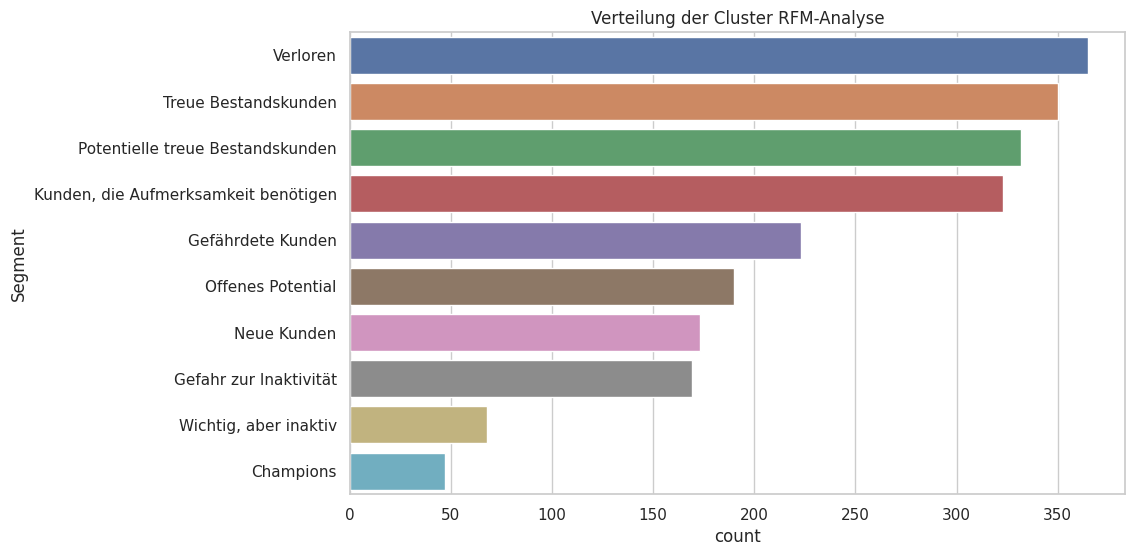

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Zählen der Häufigkeit jedes Segments im DataFrame 'dft' und Sortieren in absteigender Reihenfolge
segment_counts = dft['Segment'].value_counts().sort_values(ascending=False)

# Erstellen eines Balkendiagramms
plt.figure(figsize=(10, 6))
plr = sns.countplot(y='Segment', data=dft, order=segment_counts.index)
plr.set_title("Verteilung der Cluster RFM-Analyse")
plt.xticks(rotation=0)  # Steilerer Winkel
plt.show()

#### Silhouette Plot

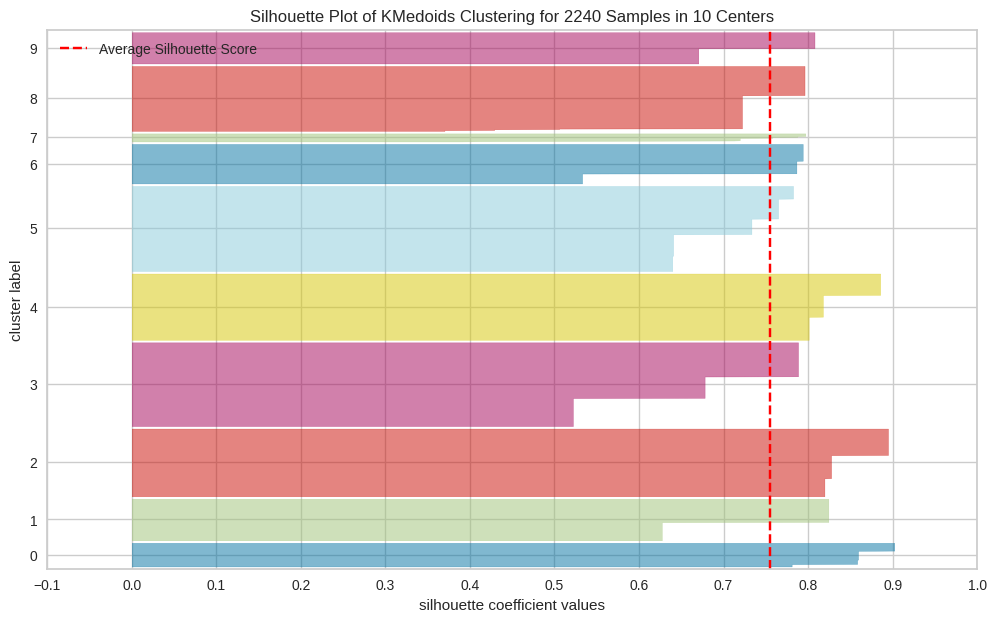

In [25]:
from yellowbrick.cluster import SilhouetteVisualizer
plt.figure(figsize=[12,7])

# Initialisieren des K-Medoids-Modells mit 10 Clustern
model = KMedoids(n_clusters=10, random_state=0, max_iter=1000,init='k-medoids++',metric='euclidean')

# Initialisieren des SilhouetteVisualizers mit dem K-Medoids-Modell
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')

# Anwenden des Visualizers auf die 'Frequency'-Daten
visualizer.fit(tx_frequencyn)

# Anzeigen der Silhouette-Visualisierung
visualizer.show()
plt.show()